In [40]:
library(Seurat)
library(tidyverse)
library(ggplot2)
library(ggrepel)
library(ggbeeswarm)
library(patchwork)
library(miloR)
options(ggrepel.max.overlaps = Inf)

In [41]:
source('milo_cellbender.R')

In [42]:
obj_neuron = qs::qread('_targets/objects/obj_neuron') %>%
             set_labels_to_lvl1 %>%
             #set_batch_to_lane %>% # do not set batch to lane for cluster splits
             prep_obj_for_milo_cb_v01 
obj_neuron

An object of class Seurat 
29128 features across 104587 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



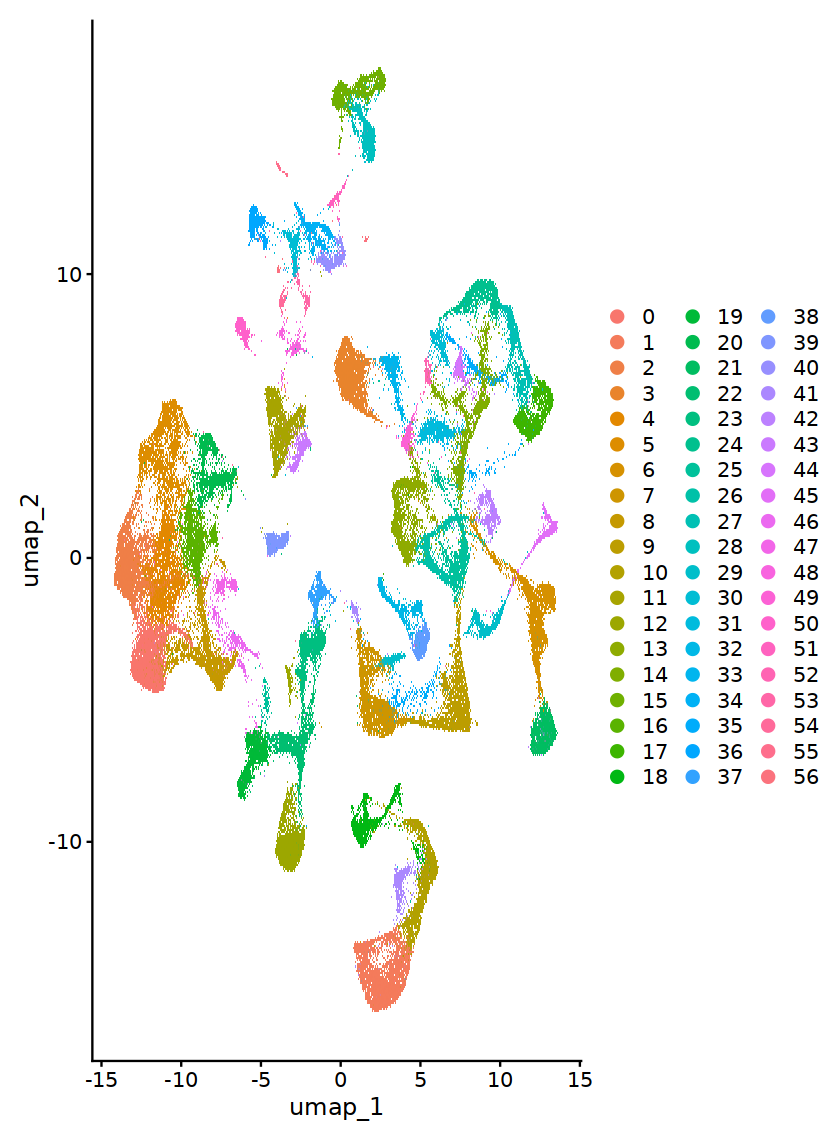

In [43]:
DimPlot(obj_neuron)

In [44]:
obj_other = qs::qread('_targets/objects/obj_other') %>%
             set_labels_to_lvl1 %>%
             #set_batch_to_lane %>% # do not set batch to lane for cluster splits
             prep_obj_for_milo_cb_v01 
obj_other

An object of class Seurat 
25033 features across 29782 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

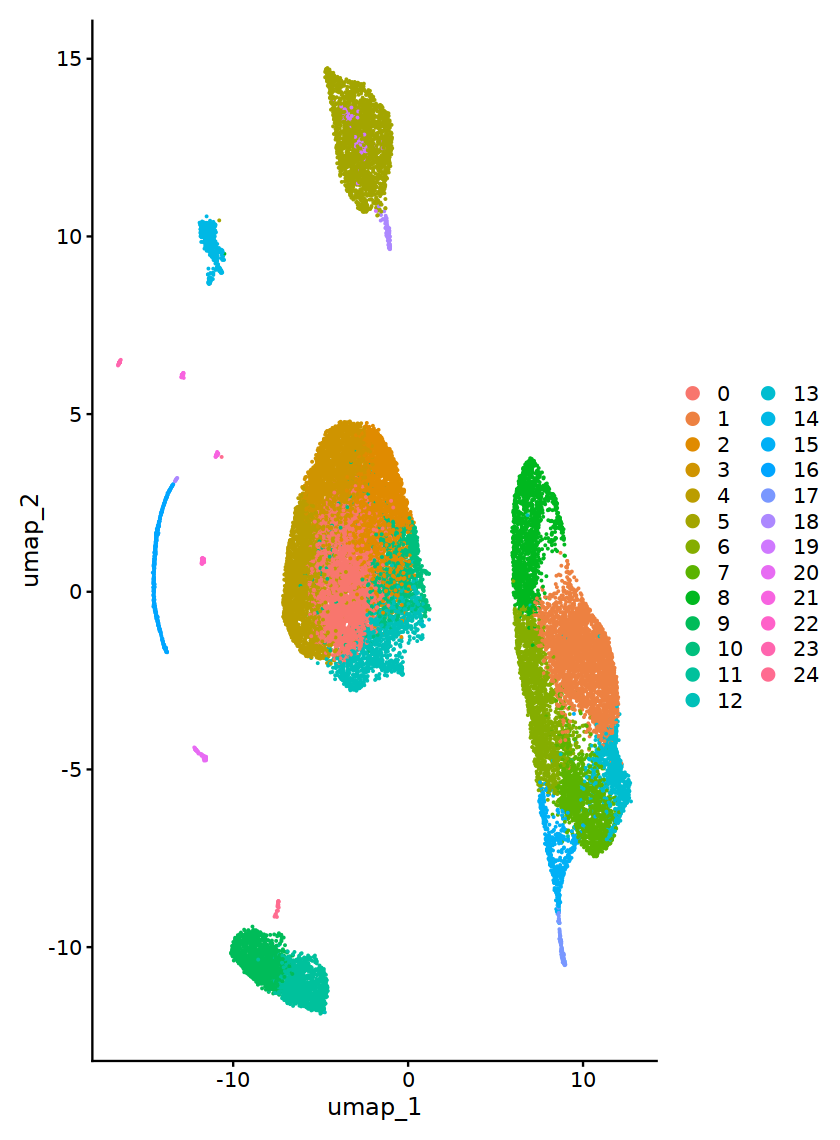

In [45]:
DimPlot(obj_other)

In [46]:
labels_classes_tib = (obj_other@meta.data %>% select(labels) %>% mutate(class = 'other') %>% tibble %>% distinct(labels, class)) %>%
bind_rows(obj_neuron@meta.data %>% select(labels) %>% mutate(class = 'neuron') %>% tibble %>% distinct(labels, class)) %>%
mutate(labels = str_replace(labels, fixed('-'), '__'))


In [47]:
umap_coords_neuron = obj_neuron %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_neuron %>% head

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAAGGTGGTTG,1.060039,-9.89935829
2,SI-TT-A11_AAACCCACATACAGCT,4.324369,1.16208909
3,SI-TT-A11_AAACCCACATGAGGGT,4.696438,-3.14927985
4,SI-TT-A11_AAACCCAGTACGTTCA,1.344125,-13.86531212
5,SI-TT-A11_AAACCCATCCAAGCAT,-5.445605,12.35118530
6,SI-TT-A11_AAACCCATCCCATAAG,-9.186716,0.09222025


In [48]:
umap_coords_other = obj_other %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_other %>% head

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAGTATCGGTT,9.741567,-6.3410525
2,SI-TT-A11_AAACGAAAGGTTCTTG,-8.439921,-10.6500720
3,SI-TT-A11_AAACGAACAAGGAGTC,-3.407435,-0.5645014
4,SI-TT-A11_AAACGAACAGCCTTCT,-4.795028,1.1611348
5,SI-TT-A11_AAACGCTAGTGCTAGG,12.090093,-5.6987538
6,SI-TT-A11_AAAGGATTCAACCCGG,8.568621,-2.9679698


In [49]:
ambiguous_cells = intersect(umap_coords_neuron %>% pull(cell_barcode), umap_coords_other %>% pull(cell_barcode))
ambiguous_cells %>% length

[1] 0

In [50]:
umap_coords_neuron = umap_coords_neuron %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords_other = umap_coords_other %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords = bind_rows(umap_coords_neuron, umap_coords_other)
umap_coords %>% dim

[1] 134369      3

In [104]:
# da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_all.obob5v5__v__all.obobBL6')
da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_all.obob5v5__v__all.obobBL6d5')
# column_to_rownames('hash.mcl.ID')

dim(da_results_restored)
da_results_restored %>% head

[1] 26179    18

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,comparison,restored,exact_grouping,restored_grouping,fgf1_grouping,bl6_grouping,hash.mcl.ID,n_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2.450720,12.34419,16.40508,9.772404e-05,0.006547510,8,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,FALSE,pos_FGF1,pos_FGF1,pos,none,SI-TT-A11_GCCGTGAGTCAGGTGA,92
2,4.058845,12.22238,17.81574,5.438004e-05,0.006072437,88,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-A11_AACCACACAGTAGAGC,66
3,4.511316,12.17780,18.34746,4.512404e-05,0.006072437,135,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-A11_TCCCATGTCTTCGGTC,60
4,2.180880,12.49469,16.47512,9.630118e-05,0.006547510,268,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,FALSE,pos_FGF1,pos_FGF1,pos,none,SI-TT-A11_CATCGGGAGAATAGTC,113
5,3.069050,12.46317,18.80759,3.801917e-05,0.006072437,326,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-E12_TCCTGCATCAAGAATG,96
6,3.369903,12.45117,15.83611,1.310836e-04,0.007318835,167,0.009178620,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-F10_AACCAACGTTCCTACC,76


In [105]:
# da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_all.obobBL6') %>%
da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_all.obobBL6d5') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y) %>%
mutate(polarity = case_when(polarity == 'none' ~ 'none',
                            polarity == 'pos' ~ 'neg',
                            polarity == 'neg' ~ 'pos')) %>%
mutate(logFC = -logFC)


dim(da_results_bl6)
da_results_bl6 %>% head

[1] 26179    12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,7.665174,12.97996,267.4013,2.192056e-28,6.598683e-26,42,3.192767e-26,pos,Agrp,1,112,SI-TT-F10_GATGTTGCATGTGACT
2,8.631823,12.94269,279.8224,3.939512e-28,6.598683e-26,164,3.192767e-26,pos,Agrp,1,108,SI-TT-E12_CTGCCTATCCCGAGGT
3,8.468071,12.92120,267.2285,1.688037e-27,1.884974e-25,97,9.205315e-26,pos,Agrp,1,107,SI-TT-G10_ACTTCGCGTCGGTACC
4,8.472501,12.88443,250.9712,1.196456e-26,1.002032e-24,168,5.045269e-25,pos,Agrp,1,104,SI-TT-F10_AGGTCTAAGGAATTAC
5,8.423193,12.82300,228.0154,2.253367e-25,1.258130e-23,50,6.747962e-24,pos,Agrp,1,98,SI-TT-F10_TCTCACGCAATTCTTC
6,8.096628,12.95989,228.2242,2.191875e-25,1.258130e-23,220,6.747962e-24,pos,Agrp,1,111,SI-TT-G10_TTCTTCCCACGGTGTC


In [107]:
da_results_fgf1 = qs::qread('_targets/objects/combined_da_results_idx_all.obob5v5') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y)


dim(da_results_fgf1)
da_results_fgf1 %>% head

[1] 26179    12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,2.450720,12.34419,16.40508,9.772404e-05,0.006547510,8,0.007936154,none,Agrp,1,92,SI-TT-A11_GCCGTGAGTCAGGTGA
2,4.058845,12.22238,17.81574,5.438004e-05,0.006072437,88,0.007936154,none,Agrp,1,66,SI-TT-A11_AACCACACAGTAGAGC
3,4.511316,12.17780,18.34746,4.512404e-05,0.006072437,135,0.007936154,none,Agrp,1,60,SI-TT-A11_TCCCATGTCTTCGGTC
4,2.180880,12.49469,16.47512,9.630118e-05,0.006547510,268,0.007936154,none,Agrp,1,113,SI-TT-A11_CATCGGGAGAATAGTC
5,3.069050,12.46317,18.80759,3.801917e-05,0.006072437,326,0.007936154,none,Agrp,1,96,SI-TT-E12_TCCTGCATCAAGAATG
6,3.369903,12.45117,15.83611,1.310836e-04,0.007318835,167,0.009178620,none,Agrp,1,76,SI-TT-F10_AACCAACGTTCCTACC


In [108]:
da_results_2 = full_join(da_results_fgf1, da_results_bl6, by=c('Nhood', 'labels'), suffix = c('_fgf1', '_bl6'))
da_results_2 %>% head

,logFC_fgf1,logCPM_fgf1,F_fgf1,PValue_fgf1,FDR_fgf1,Nhood,SpatialFDR_fgf1,polarity_fgf1,labels,labels_fraction_fgf1,⋯,logFC_bl6,logCPM_bl6,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,hash.mcl.ID_bl6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,2.450720,12.34419,16.40508,9.772404e-05,0.006547510,8,0.007936154,none,Agrp,1,⋯,1.3305454,12.34419,1.8702874,1.743399e-01,2.100859e-01,2.047633e-01,none,1,92,SI-TT-A11_GCCGTGAGTCAGGTGA
2,4.058845,12.22238,17.81574,5.438004e-05,0.006072437,88,0.007936154,none,Agrp,1,⋯,5.9860922,12.22238,33.1905388,9.623187e-08,5.117092e-07,3.978463e-07,pos,1,66,SI-TT-A11_AACCACACAGTAGAGC
3,4.511316,12.17780,18.34746,4.512404e-05,0.006072437,135,0.007936154,none,Agrp,1,⋯,7.0169682,12.17780,39.2284087,1.185981e-08,6.408121e-08,4.946585e-08,pos,1,60,SI-TT-A11_TCCCATGTCTTCGGTC
4,2.180880,12.49469,16.47512,9.630118e-05,0.006547510,268,0.007936154,none,Agrp,1,⋯,0.7027274,12.49469,0.6079135,4.373657e-01,4.726371e-01,4.668054e-01,none,1,113,SI-TT-A11_CATCGGGAGAATAGTC
5,3.069050,12.46317,18.80759,3.801917e-05,0.006072437,326,0.007936154,none,Agrp,1,⋯,3.0201593,12.46317,9.5434859,2.677471e-03,9.198482e-03,7.849727e-03,pos,1,96,SI-TT-E12_TCCTGCATCAAGAATG
6,3.369903,12.45117,15.83611,1.310836e-04,0.007318835,167,0.009178620,none,Agrp,1,⋯,6.7152221,12.45117,70.9136655,2.833548e-13,1.608879e-12,1.213283e-12,pos,1,76,SI-TT-F10_AACCAACGTTCCTACC


In [109]:
da_results = da_results_restored %>% full_join(da_results_2, by=c('Nhood', 'labels')) %>%
mutate(exact_grouping = case_when(is.na(exact_grouping) & (polarity_bl6 != 'none') ~ paste0(polarity_bl6, '_BL6'),
                                  is.na(exact_grouping) & (polarity_bl6 == 'none') ~ paste0(polarity_bl6),
                                  TRUE ~ exact_grouping)) %>%
mutate(n_cells = n_cells_fgf1) %>%
left_join(labels_classes_tib, by='labels') %>%
mutate(cell_barcode = hash.mcl.ID_fgf1) %>%
relocate(cell_barcode, .after='hash.mcl.ID') %>%
select(-all_of(c("hash.mcl.ID", "hash.mcl.ID_fgf1", "hash.mcl.ID_bl6"))) %>%
left_join(umap_coords, by='cell_barcode') %>%
mutate(polarity_bl6 = case_when(logFC_bl6 > 0 & SpatialFDR_bl6 < 0.1 ~ 'pos',
                                logFC_bl6 < 0 & SpatialFDR_bl6 < 0.1 ~ 'neg',
                                TRUE ~ 'none')) %>%
mutate(polarity_fgf1 = case_when(logFC_fgf1 > 0 & SpatialFDR_fgf1 < 0.1 ~ 'pos',
                                logFC_fgf1 < 0 & SpatialFDR_fgf1 < 0.1 ~ 'neg',
                                TRUE ~ 'none'))

da_results %>% dim
da_results %>% head

[1] 26179    39

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,⋯,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,class,umap_1,umap_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,2.450720,12.34419,16.40508,9.772404e-05,0.006547510,8,0.007936154,pos,Agrp,1,⋯,1.8702874,1.743399e-01,2.100859e-01,2.047633e-01,none,1,92,neuron,4.024358,-13.21293
2,4.058845,12.22238,17.81574,5.438004e-05,0.006072437,88,0.007936154,pos,Agrp,1,⋯,33.1905388,9.623187e-08,5.117092e-07,3.978463e-07,pos,1,66,neuron,3.799933,-12.97150
3,4.511316,12.17780,18.34746,4.512404e-05,0.006072437,135,0.007936154,pos,Agrp,1,⋯,39.2284087,1.185981e-08,6.408121e-08,4.946585e-08,pos,1,60,neuron,3.227394,-13.47334
4,2.180880,12.49469,16.47512,9.630118e-05,0.006547510,268,0.007936154,pos,Agrp,1,⋯,0.6079135,4.373657e-01,4.726371e-01,4.668054e-01,none,1,113,neuron,4.279744,-13.61656
5,3.069050,12.46317,18.80759,3.801917e-05,0.006072437,326,0.007936154,pos,Agrp,1,⋯,9.5434859,2.677471e-03,9.198482e-03,7.849727e-03,pos,1,96,neuron,3.307137,-13.49501
6,3.369903,12.45117,15.83611,1.310836e-04,0.007318835,167,0.009178620,pos,Agrp,1,⋯,70.9136655,2.833548e-13,1.608879e-12,1.213283e-12,pos,1,76,neuron,4.424284,-13.29926


In [110]:
da_results_restored 

logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,comparison,restored,exact_grouping,restored_grouping,fgf1_grouping,bl6_grouping,hash.mcl.ID,n_cells
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2.450720,12.34419,16.405083,9.772404e-05,0.006547510,8,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,FALSE,pos_FGF1,pos_FGF1,pos,none,SI-TT-A11_GCCGTGAGTCAGGTGA,92
4.058845,12.22238,17.815742,5.438004e-05,0.006072437,88,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-A11_AACCACACAGTAGAGC,66
4.511316,12.17780,18.347462,4.512404e-05,0.006072437,135,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-A11_TCCCATGTCTTCGGTC,60
2.180880,12.49469,16.475121,9.630118e-05,0.006547510,268,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,FALSE,pos_FGF1,pos_FGF1,pos,none,SI-TT-A11_CATCGGGAGAATAGTC,113
3.069050,12.46317,18.807591,3.801917e-05,0.006072437,326,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-E12_TCCTGCATCAAGAATG,96
3.369903,12.45117,15.836112,1.310836e-04,0.007318835,167,0.009178620,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-F10_AACCAACGTTCCTACC,76
3.237844,12.20964,14.975725,1.886269e-04,0.009027144,314,0.011428638,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-H10_GGTTCTCCAACCAGAG,66
2.096936,12.42957,14.560063,2.320691e-04,0.009717894,47,0.011964036,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,FALSE,pos_FGF1,pos_FGF1,pos,none,SI-TT-H10_CAGTTAGTCCGTCCTA,106
3.492525,12.20746,14.204290,2.800721e-04,0.010424908,284,0.012926995,pos,Agrp,1,all.obob5v5__v__all.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-A11_ATATCCTAGCGCACAA,64


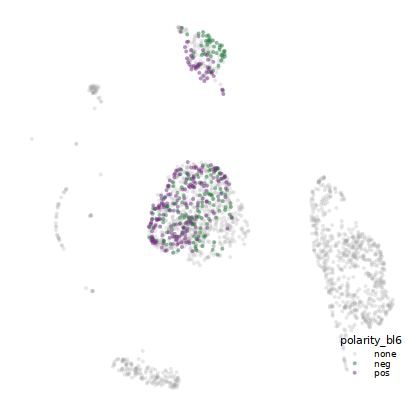

In [111]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_bl6_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_other 

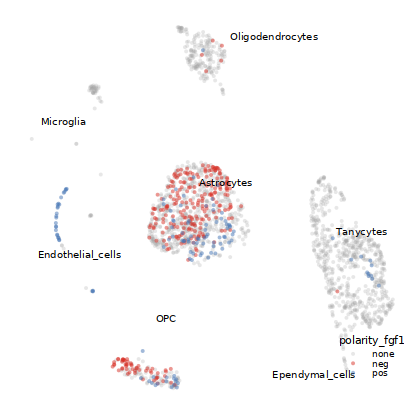

In [112]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
label_data <- da_results %>%
  filter(class == 'other') %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(1, "lines"), 
              point.padding = unit(2, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_other 

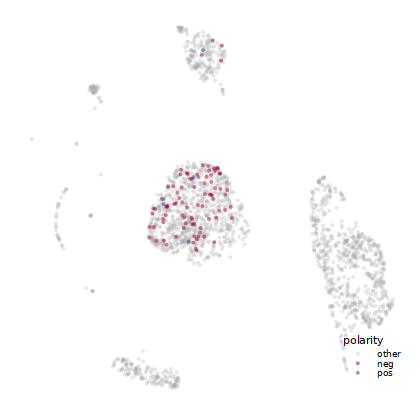

In [113]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_restored_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_other 

In [115]:
all_restored_summary = qs::qread('_targets/objects/all_restored_summary') %>%
filter(comparison == 'all.obob5v5__v__all.obobBL6d5') %>%
mutate(prop_fgf1 = n_fgf1/n_total) %>%
mutate(prop_BL6 = n_BL6/n_total) %>%
mutate(prop_sum = prop_fgf1 + prop_BL6) %>%
mutate(n_sum = n_fgf1 + n_BL6) %>%
arrange(desc(n_fgf1))

all_restored_summary %>% head

label_order = all_restored_summary %>% pull(labels)
label_order

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
other,1718,408,187,221,0.4583333,88,29,27,2,0.3295455,0.07107843,all.obob5v5__v__all.obobBL6d5,0.2374854,0.05122235,0.2887078,496
g2,868,290,89,201,0.3068966,318,79,6,73,0.2484277,0.27241379,all.obob5v5__v__all.obobBL6d5,0.3341014,0.36635945,0.7004608,608
Astrocytes,910,284,66,218,0.2323944,312,87,4,83,0.2788462,0.30633803,all.obob5v5__v__all.obobBL6d5,0.3120879,0.34285714,0.6549451,596
OPC,182,95,41,54,0.4315789,0,0,0,0,NaN,0.00000000,all.obob5v5__v__all.obobBL6d5,0.5219780,0.00000000,0.5219780,95
Htr3b,254,90,28,62,0.3111111,35,9,4,5,0.2571429,0.10000000,all.obob5v5__v__all.obobBL6d5,0.3543307,0.13779528,0.4921260,125
g3,349,80,36,44,0.4500000,0,0,0,0,NaN,0.00000000,all.obob5v5__v__all.obobBL6d5,0.2292264,0.00000000,0.2292264,80


[1] "other"               "g2"                  "Astrocytes"         
 [4] "OPC"                 "Htr3b"               "g3"                 
 [7] "neuron"              "Trh__Lef1"           "n1"                 
[10] "g1"                  "Agrp"                "Tanycytes"          
[13] "Irx5__Lmx1a"         "n0"                  "Ghrh"               
[16] "n8"                  "Oligodendrocytes"    "Kiss1__Tac2"        
[19] "n_drop"              "Endothelial_cells"   "Pomc__Glipr1"       
[22] "Nfib_3"              "Nfix__Nfib__Lhx6"    "Pomc__Ttr"          
[25] "Pou6f2__Prkcq__Whrn" "Ppp1r17__Tafa4"      "Arx__Nr5a2"         
[28] "Dlk1"                "Ependymal_cells"     "Esr1"               
[31] "Fez1"                "Gpr50__Tac2"         "Hdc"                
[34] "Lepr15"              "Lepr67"              "Lepr89"             
[37] "Lpar1_oligo"         "Met__Pappa2"         "Met__Prlh"          
[40] "Microglia"           "Nfib_1"              "Nfib_2"             
[43] "Nfix__Nfib"          "Nfix__Nfib__Hgf"     "Npsr1__Epha3"       
[46] "Pomc__Anxa2"         "Ppp1r17"             "Ppp1r17__Ltbp1"     
[49] "Reln__Lef1"          "Sim1"                "Slc17a6__Trhr"      
[52] "Sst__Nts"            "Sst__Pthlh"          "Sst__Unc13c"        
[55] "Tbx19__Pirt"         "Th__Nfib"            "Th__Slc6a3"         
[58] "Tmem215__Dach2"      "Tmem215__Greb1"      "Trh__Cxcl12"        
[61] "g4"                  "g_drop"              "n2"                 
[64] "n3"                  "n4"                  "n5"                 
[67] "n6"

In [116]:
all_restored_summary %>% filter(prop_sum > 0) %>%
left_join(labels_classes_tib, by='labels') %>%
group_by(class) %>% summarise(n=n())

class,n
<chr>,<int>
neuron,23
other,5
NA,12


In [117]:
all_restored_summary %>%
left_join(labels_classes_tib, by='labels') %>%
filter(class=='neuron') %>%
arrange(desc(n_sum)) %>%
head(20)

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum,class
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>
Agrp,335,14,13,1,0.9285714,249,8,7,1,0.03212851,0.5714286,all.obob5v5__v__all.obobBL6d5,0.041791045,0.74328358,0.785074627,263,neuron
Kiss1__Tac2,213,4,2,2,0.5000000,132,4,2,2,0.03030303,1.0000000,all.obob5v5__v__all.obobBL6d5,0.018779343,0.61971831,0.638497653,136,neuron
Trh__Cxcl12,268,0,NA,NA,NA,134,0,0,0,0.00000000,NaN,all.obob5v5__v__all.obobBL6d5,0.000000000,0.50000000,0.500000000,134,neuron
Htr3b,254,90,28,62,0.3111111,35,9,4,5,0.25714286,0.1000000,all.obob5v5__v__all.obobBL6d5,0.354330709,0.13779528,0.492125984,125,neuron
Ghrh,148,9,9,NA,1.0000000,92,9,9,0,0.09782609,1.0000000,all.obob5v5__v__all.obobBL6d5,0.060810811,0.62162162,0.682432432,101,neuron
Sst__Unc13c,242,0,NA,NA,NA,77,0,0,0,0.00000000,NaN,all.obob5v5__v__all.obobBL6d5,0.000000000,0.31818182,0.318181818,77,neuron
Tmem215__Greb1,173,0,NA,NA,NA,61,0,0,0,0.00000000,NaN,all.obob5v5__v__all.obobBL6d5,0.000000000,0.35260116,0.352601156,61,neuron
Pomc__Ttr,105,2,2,NA,1.0000000,37,1,1,0,0.02702703,0.5000000,all.obob5v5__v__all.obobBL6d5,0.019047619,0.35238095,0.371428571,39,neuron
Pomc__Glipr1,166,3,NA,3,NA,33,2,0,2,0.06060606,0.6666667,all.obob5v5__v__all.obobBL6d5,0.018072289,0.19879518,0.216867470,36,neuron


In [118]:
unchanged_labels = all_restored_summary %>%
filter(!(prop_sum > 0)) %>%
pull(labels)
unchanged_labels

[1] "Arx__Nr5a2"      "Dlk1"            "Ependymal_cells" "Esr1"           
 [5] "Fez1"            "Gpr50__Tac2"     "Hdc"             "Lepr15"         
 [9] "Lepr67"          "Lepr89"          "Met__Pappa2"     "Microglia"      
[13] "Nfib_1"          "Nfib_2"          "Nfix__Nfib"      "Npsr1__Epha3"   
[17] "Ppp1r17"         "Ppp1r17__Ltbp1"  "Reln__Lef1"      "Sim1"           
[21] "Slc17a6__Trhr"   "Sst__Nts"        "Sst__Pthlh"      "g4"             
[25] "g_drop"          "n4"              "n6"

In [119]:
all_restored_summary %>%
filter(str_detect(labels, 'Ghrh'))

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
Ghrh,148,9,9,NA,1,92,9,9,0,0.09782609,1,all.obob5v5__v__all.obobBL6d5,0.06081081,0.6216216,0.6824324,101


In [120]:
beeswarm_tibble = da_results %>%
select(Nhood, labels, class, n_cells, polarity_fgf1, SpatialFDR_fgf1, logFC_fgf1, polarity_bl6, SpatialFDR_bl6, logFC_bl6, exact_grouping) %>%
mutate(restored = case_when(exact_grouping == 'pos_restored' ~ 'yes',
                             exact_grouping == 'neg_restored' ~ 'yes',
                             TRUE ~ 'no')) %>%
mutate(restored = factor(restored, levels=c('no', 'yes')))

# Separate data frames for each type of measurement
polarity_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("polarity"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("polarity"),
               names_to = "comparison",
               values_to = "polarity") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

spatial_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("SpatialFDR"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("SpatialFDR"),
               names_to = "comparison",
               values_to = "SpatialFDR") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

logfc_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("logFC"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("logFC"),
               names_to = "comparison",
               values_to = "logFC") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

# Join all dataframes
beeswarm_tibble <- polarity_df %>%
  inner_join(spatial_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored")) %>%
  inner_join(logfc_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored"))


beeswarm_tibble = beeswarm_tibble %>%
mutate(labels = factor(labels, levels=rev(label_order))) %>%
rowwise %>%
mutate(label.group = paste0(labels, '.', comparison)) %>% 
ungroup %>%
mutate(polarity = paste0(polarity, '.', comparison)) %>%
mutate(polarity = case_when(str_detect(polarity, 'none') ~ 'none',
                            TRUE ~ polarity)) %>%
mutate(polarity = factor(polarity, levels=rev(c('none', 'neg.BL6', 'pos.BL6', 'neg.FGF1', 'pos.FGF1')))) %>%
arrange(desc(labels))

beeswarm_tibble

Nhood,labels,class,n_cells,exact_grouping,restored,comparison,polarity,SpatialFDR,logFC,label.group
<dbl>,<fct>,<chr>,<dbl>,<chr>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<chr>
1428,other,NA,79,pos_FGF1,no,FGF1,pos.FGF1,2.347613e-09,6.750158277,other.FGF1
1428,other,NA,79,pos_FGF1,no,BL6,none,5.607009e-01,1.482439503,other.BL6
413,other,NA,70,pos_FGF1,no,FGF1,pos.FGF1,1.042167e-08,6.557009383,other.FGF1
413,other,NA,70,pos_FGF1,no,BL6,none,9.999971e-01,-0.005612221,other.BL6
1232,other,NA,63,pos_FGF1,no,FGF1,pos.FGF1,1.042167e-08,6.418106423,other.FGF1
1232,other,NA,63,pos_FGF1,no,BL6,none,5.571011e-01,1.397525135,other.BL6
80,other,NA,73,pos_FGF1,no,FGF1,pos.FGF1,4.248249e-08,5.036261086,other.FGF1
80,other,NA,73,pos_FGF1,no,BL6,none,9.678296e-01,-0.181317216,other.BL6
684,other,NA,73,pos_FGF1,no,FGF1,pos.FGF1,1.580262e-07,4.582709103,other.FGF1


In [121]:
beeswarm_tibble %>% head %>% print

# A tibble: 6 × 11
  Nhood labels class n_cells exact_grouping restored comparison polarity
  <dbl> <fct>  <chr>   <dbl> <chr>          <fct>    <chr>      <fct>   
1  1428 other  NA         79 pos_FGF1       no       FGF1       pos.FGF1
2  1428 other  NA         79 pos_FGF1       no       BL6        none    
3   413 other  NA         70 pos_FGF1       no       FGF1       pos.FGF1
4   413 other  NA         70 pos_FGF1       no       BL6        none    
5  1232 other  NA         63 pos_FGF1       no       FGF1       pos.FGF1
6  1232 other  NA         63 pos_FGF1       no       BL6        none    
# ℹ 3 more variables: SpatialFDR <dbl>, logFC <dbl>, label.group <chr>


In [122]:
beeswarm_tibble %>% pull(polarity) %>% unique
beeswarm_tibble %>% pull(polarity) %>% levels

[1] pos.FGF1 none     neg.FGF1 pos.BL6  neg.BL6 
Levels: pos.FGF1 neg.FGF1 pos.BL6 neg.BL6 none

[1] "pos.FGF1" "neg.FGF1" "pos.BL6"  "neg.BL6"  "none"

In [123]:
beeswarm_tibble %>% filter(restored == 'yes') %>% dim

[1] 558  11

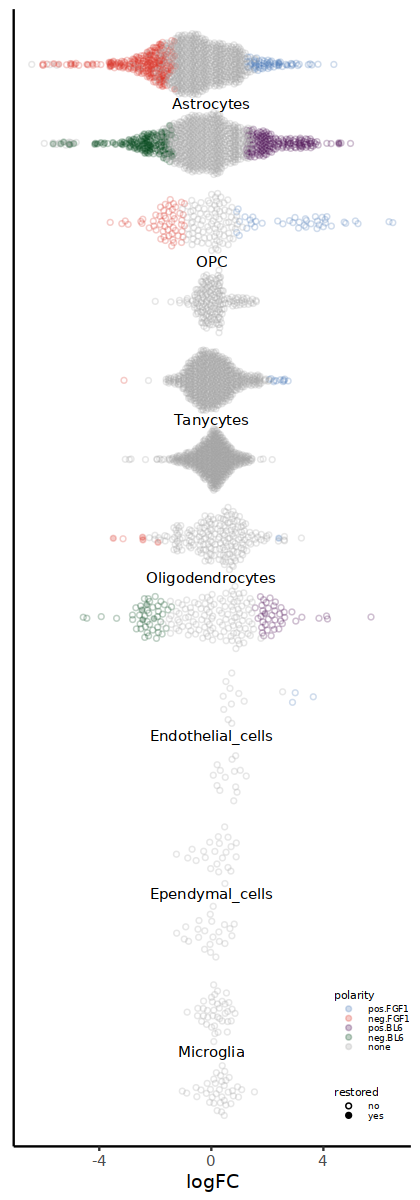

In [124]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- beeswarm_tibble %>%
  filter(class == 'other')  %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  distinct(labels)

beeswarm_other = beeswarm_tibble %>%
  filter(class == 'other') %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.9,0.08)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))
beeswarm_other

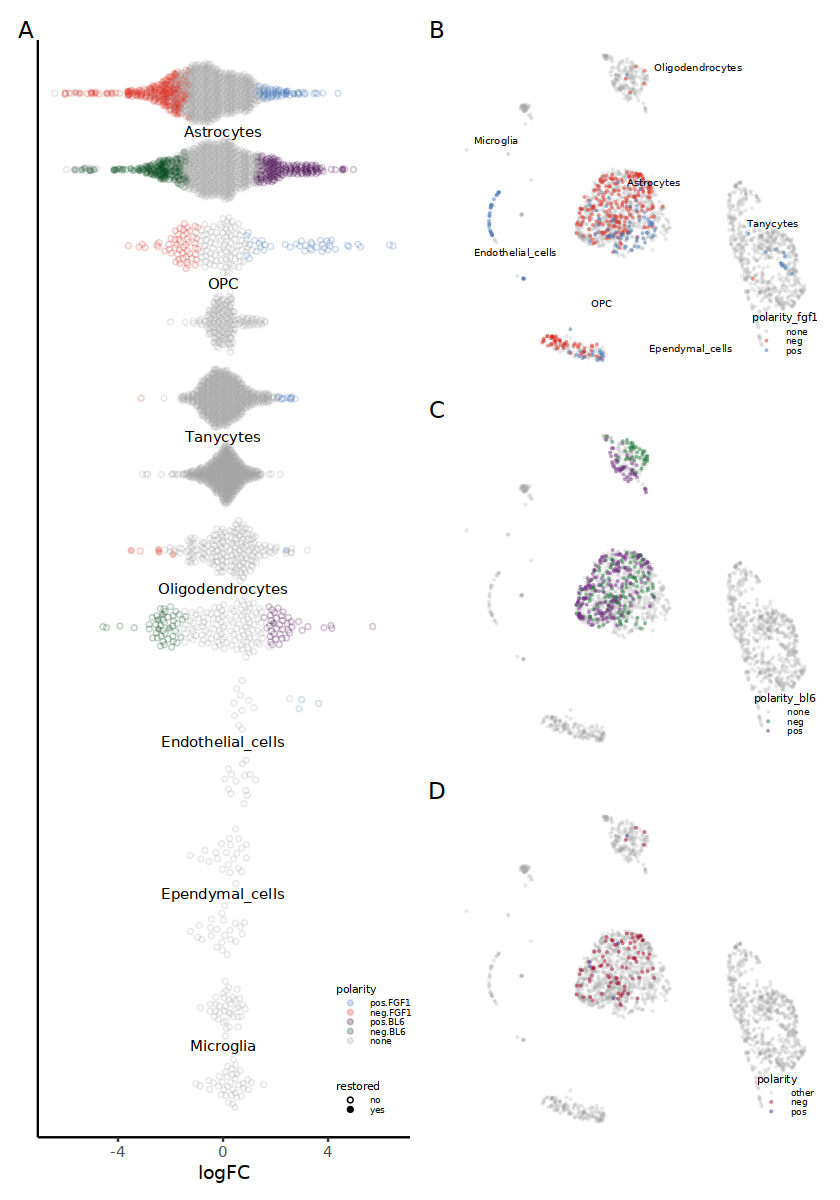

In [125]:
options(repr.plot.width=7, repr.plot.height=10)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_other,
           B = umap_fgf1_other,
           C = umap_bl6_other,
           D = umap_restored_other,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_other_all_d5.pdf', plot = ., width = 7, height=9)
ggp

In [126]:
unchanged_labels_bl6 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_bl6 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
# filter(n == 1) %>%
pull(labels)

unchanged_labels_bl6

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] "Agrp"                "Arx__Nr5a2"          "Astrocytes"         
 [4] "Dlk1"                "Endothelial_cells"   "Ependymal_cells"    
 [7] "Esr1"                "Fez1"                "Ghrh"               
[10] "Gpr50__Tac2"         "Hdc"                 "Htr3b"              
[13] "Irx5__Lmx1a"         "Kiss1__Tac2"         "Lepr15"             
[16] "Lepr67"              "Lepr89"              "Lpar1_oligo"        
[19] "Met__Pappa2"         "Met__Prlh"           "Microglia"          
[22] "Nfib_1"              "Nfib_2"              "Nfib_3"             
[25] "Nfix__Nfib"          "Nfix__Nfib__Hgf"     "Nfix__Nfib__Lhx6"   
[28] "Npsr1__Epha3"        "OPC"                 "Oligodendrocytes"   
[31] "Pomc__Anxa2"         "Pomc__Glipr1"        "Pomc__Ttr"          
[34] "Pou6f2__Prkcq__Whrn" "Ppp1r17"             "Ppp1r17__Ltbp1"     
[37] "Ppp1r17__Tafa4"      "Reln__Lef1"          "Sim1"               
[40] "Slc17a6__Trhr"       "Sst__Nts"            "Sst__Pthlh"         
[43] "Sst__Unc13c"         "Tanycytes"           "Tbx19__Pirt"        
[46] "Th__Nfib"            "Th__Slc6a3"          "Tmem215__Dach2"     
[49] "Tmem215__Greb1"      "Trh__Cxcl12"         "Trh__Lef1"          
[52] "g1"                  "g2"                  "g3"                 
[55] "g4"                  "g_drop"              "n0"                 
[58] "n1"                  "n2"                  "n3"                 
[61] "n4"                  "n5"                  "n6"                 
[64] "n8"                  "n_drop"              "neuron"             
[67] "other"

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] 35

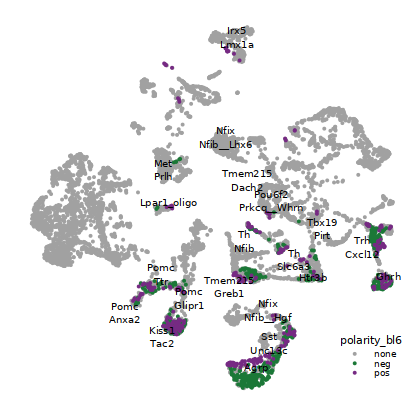

In [127]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_bl6 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_bl6 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_bl6 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_bl6_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 1, "neg" = 1, "pos"=1)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_neuron

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] 41

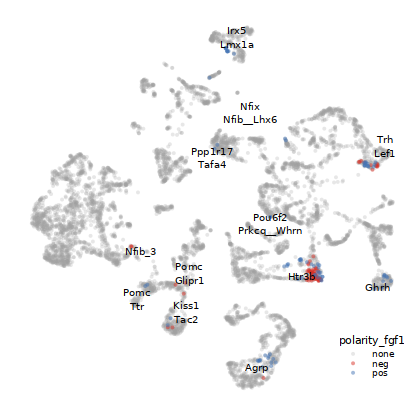

In [128]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_fgf1 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_fgf1 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_fgf1 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_neuron 

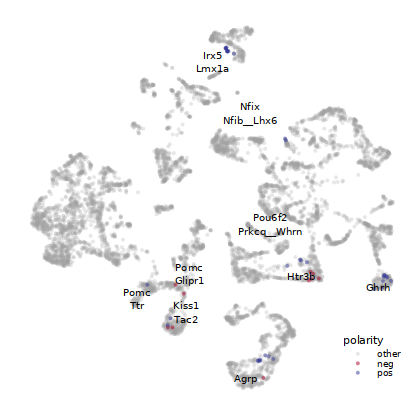

In [129]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_restored_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_neuron 

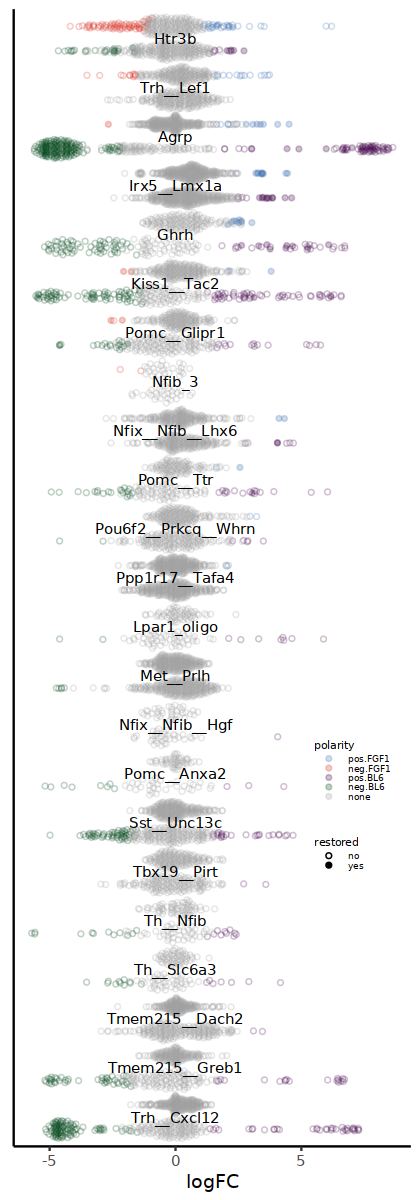

In [130]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- da_results %>%
  filter(class == 'neuron') %>%
  filter((polarity_fgf1 %in% c('pos', 'neg')) | (polarity_bl6 %in% c('pos', 'neg'))) %>%
  distinct(labels)

beeswarm_neuron = beeswarm_tibble %>%
  filter(class == 'neuron') %>%
  filter((labels %in% label_tibble$labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.85,0.3)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

beeswarm_neuron

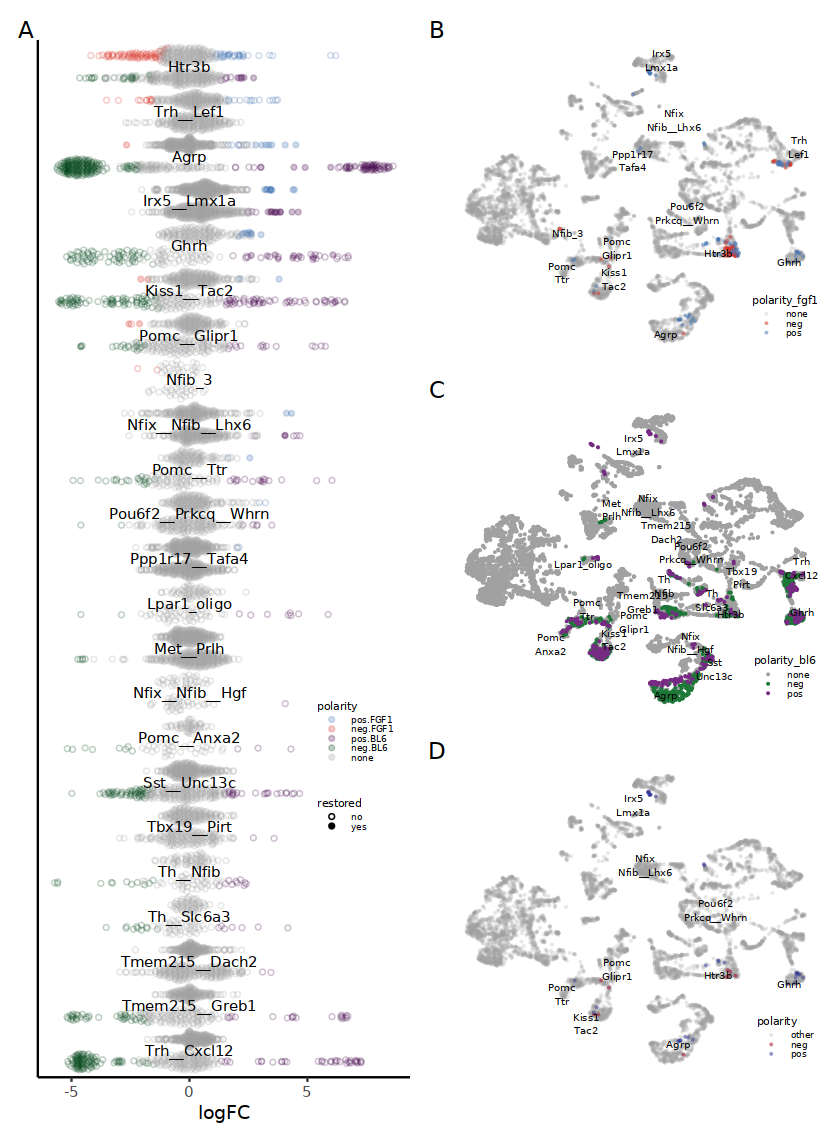

In [131]:
options(repr.plot.width=7, repr.plot.height=9.5)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_neuron,
           B = umap_fgf1_neuron,
           C = umap_bl6_neuron,
           D = umap_restored_neuron,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_neurons_all_d5.pdf', plot = ., width = 7, height=9)
ggp

In [132]:
beeswarm_tibble %>% qs::qsave('beeswarm_tibble_d5.qs')
da_results %>% qs::qsave('beeswarm_da_results_d5.qs')